## Imports

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load and Clean

In [2]:
data_path = 'Bike-Sharing-Dataset/hour.csv'

rides = pd.read_csv(data_path)

In [3]:
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## Plotting

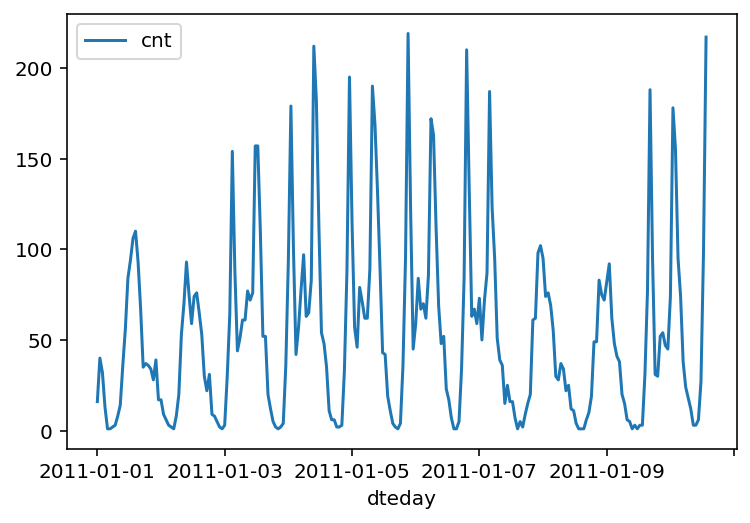

In [4]:
rides[:24*10].plot(x='dteday', y='cnt')

### Dummy variables

In [5]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


### Standardization (Scaling) 

In [6]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']

scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

### Splitting

In [7]:
test_data = data[-21*24:]

data = data[:-21*24]

target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

In [8]:
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

In [9]:
from my_answers import NeuralNetwork

In [10]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

## Unit tests

In [11]:
import unittest

inputs = np.array([[0.5, -0.2, 0.1]])
targets = np.array([[0.4]])
test_w_i_h = np.array([[0.1, -0.2],
                       [0.4, 0.5],
                       [-0.3, 0.2]])
test_w_h_o = np.array([[0.3],
                       [-0.1]])

class TestMethods(unittest.TestCase):
    
    def test_data_path(self):
        # Test for correct file path 
        self.assertTrue(data_path.lower() == 'bike-sharing-dataset/hour.csv')
        
    def test_data_loaded(self):
        self.assertTrue(isinstance(rides, pd.DataFrame))
    
    #Test functionality
    def test_activation(self):
        network = NeuralNetwork(3, 2, 1, 0.5)
        # Test that the activation function is a sigmoid
        self.assertTrue(np.all(network.activation_function(0.5) == 1/(1+np.exp(-0.5))))

    def test_train(self):
        # Test correct weight updation
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()
        
        network.train(inputs, targets)
        self.assertTrue(np.allclose(network.weights_hidden_to_output, 
                                    np.array([[ 0.37275328], 
                                              [-0.03172939]])))
        self.assertTrue(np.allclose(network.weights_input_to_hidden,
                                    np.array([[ 0.10562014, -0.20185996], 
                                              [0.39775194, 0.50074398], 
                                              [-0.29887597, 0.19962801]])))

    def test_run(self):
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()

        self.assertTrue(np.allclose(network.run(inputs), 0.09998924))

suite = unittest.TestLoader().loadTestsFromModule(TestMethods())
unittest.TextTestRunner().run(suite)

.....
----------------------------------------------------------------------
Ran 5 tests in 0.015s

OK


<unittest.runner.TextTestResult run=5 errors=0 failures=0>

## Training

In [14]:
import sys

from my_answers import iterations, learning_rate, hidden_nodes, output_nodes


N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for ii in range(iterations):
    # Go through a random batch of 128 records from the training data set
    batch = np.random.choice(train_features.index, size=128)
    X, y = train_features.iloc[batch].values, train_targets.iloc[batch]['cnt']
                             
    network.train(X, y)
    
    # Printing out the training progress
    train_loss = MSE(network.run(train_features).T, train_targets['cnt'].values)
    val_loss = MSE(network.run(val_features).T, val_targets['cnt'].values)
    sys.stdout.write("\rProgress: {:2.1f}".format(100 * ii/float(iterations)) \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    sys.stdout.flush()
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

Progress: 100.0% ... Training loss: 0.061 ... Validation loss: 0.144

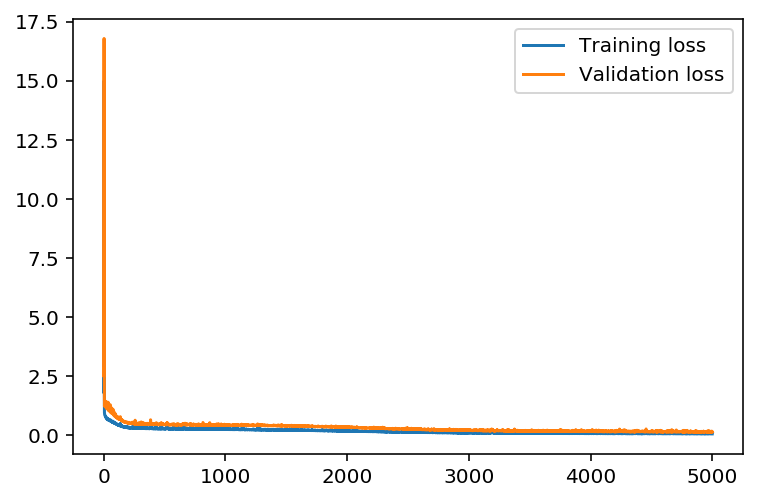

In [15]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
_ = plt.ylim()

## Test

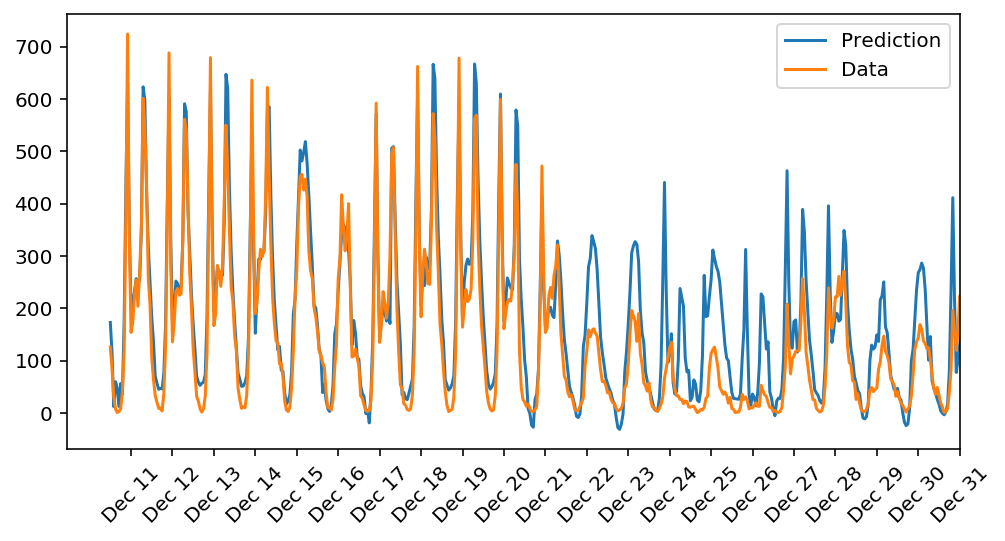

In [17]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['cnt']
predictions = network.run(test_features).T*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.iloc[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)